<div class="alert alert-warning">
<h1>Advanced Statistical Inference - Assessed Exercise</h1>
<h2>Daniele Reda</h2>
</div>

<h3>Note on color codings</h3>
<div class="label label-warning">Yellow</div> is used for titles and subtitles
<div class="label label-default">Transparent</div> is used for formulas, explanations and informations
<div class="label label-info">Blue</div> is used to write the questions asked by the assessed exercise
<div class="label label-success">Green</div> is used for the answers to the questions
<div class="label label-danger">Red</div> is for to-dos (hopefully you shouldn't see any of these)

<h3>Introduction and Instruction</h3>
<br>
In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
<br>
<ul>
<li>http://yann.lecun.com/exdb/mnist/
<li>https://www.cs.toronto.edu/~kriz/cifar.html
</ul>
<br>
Listed below are various exercises to undertake.

<div class="alert alert-info">
Download the MNIST and CIFAR10 datasets and import them.
</div>

In [2]:
from keras.datasets import mnist, cifar10

(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar10_train_data, cifar10_train_label), (cifar10_test_data, cifar10_test_label) = cifar10.load_data()

Using TensorFlow backend.


<div class="alert alert-info">
Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.
</div>

In [3]:
import os
import sys
import re
import random
import functools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from time import time
from sklearn.metrics import confusion_matrix
import itertools

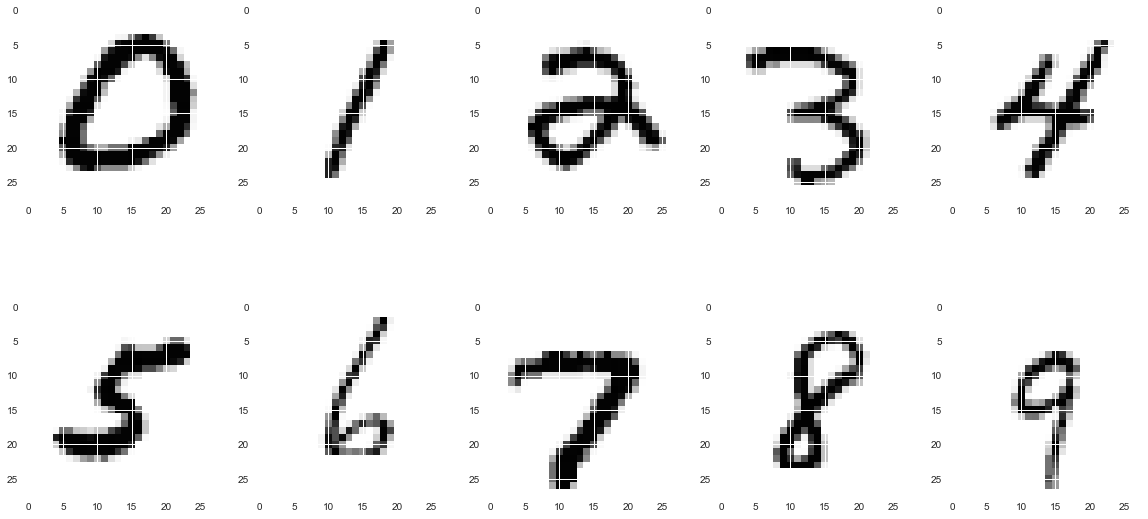

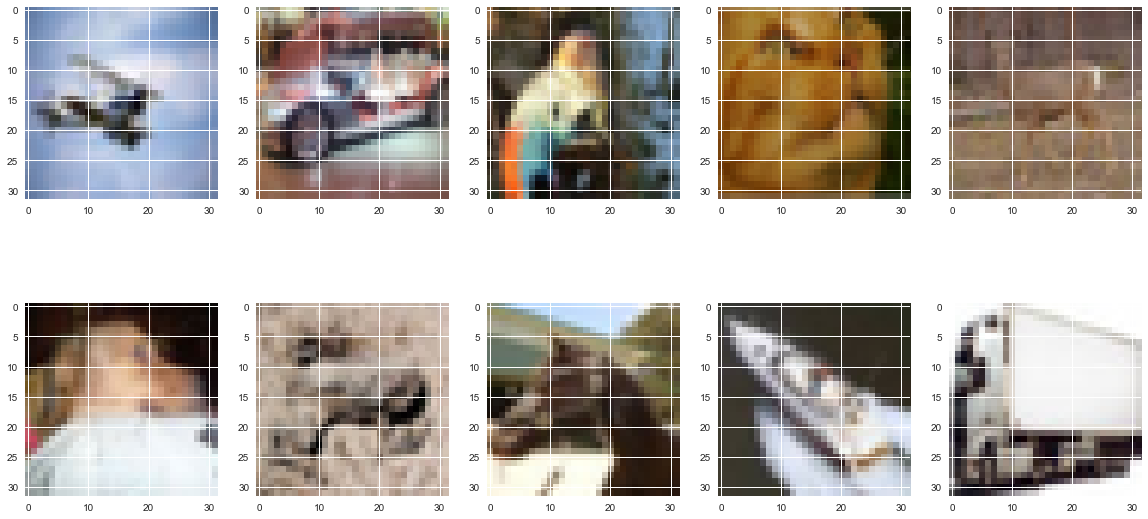

In [122]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
fig, axes = plt.subplots(2,5)
dist_mnist = []
for k, ax in enumerate(axes.flatten()):
    x = [mnist_train_data[_] for _ in np.arange(len(mnist_train_data)) if mnist_train_label[_]==k]
    dist_mnist.append(x)
    ax.imshow(x[np.random.randint(0, len(x))])
plt.show()

fig, axes = plt.subplots(2,5)
dist_cifar = []
for k, ax in enumerate(axes.flatten()):
    x = [cifar10_train_data[_] for _ in np.arange(len(cifar10_train_data)) if cifar10_train_label[_]==k]
    dist_cifar.append(x)
    ax.imshow(x[np.random.randint(0, len(x))])
plt.show()

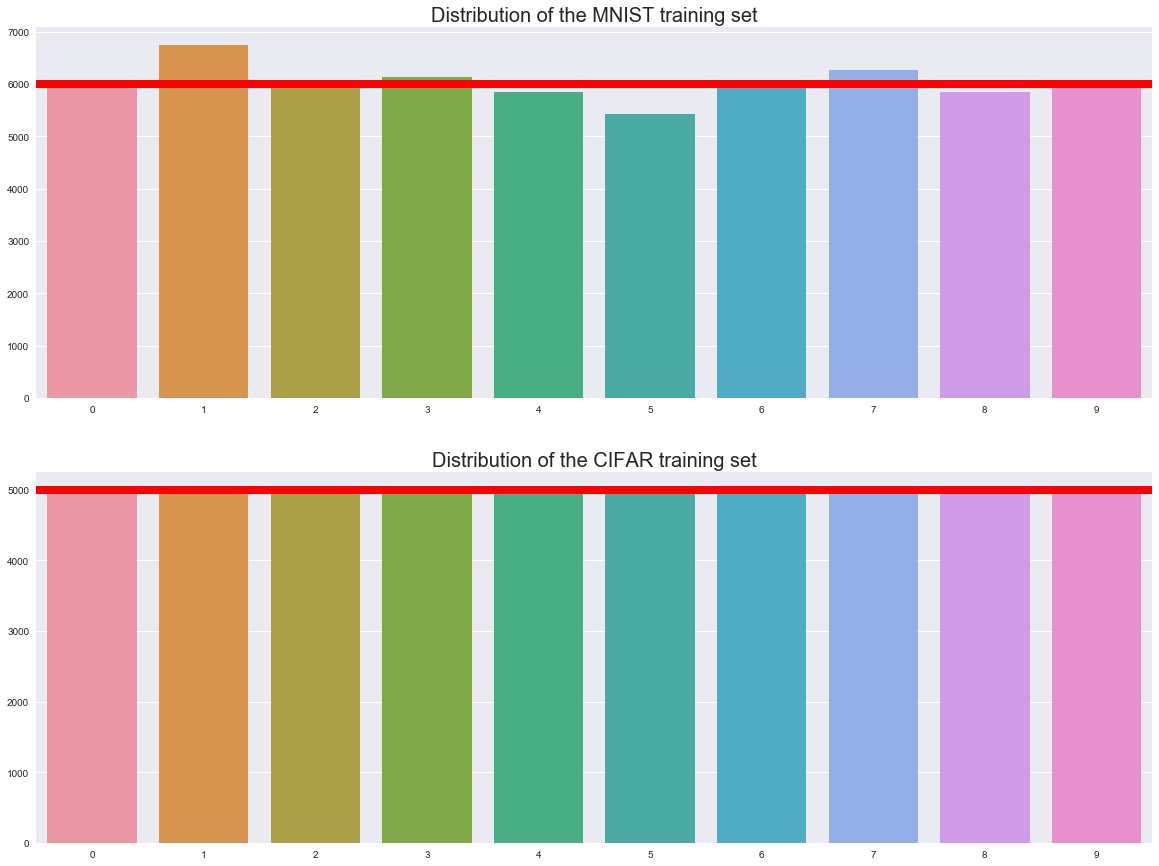

In [123]:
plt.figure(figsize=(20,15))
plt.subplot(211)
sns.barplot(x=np.arange(len(dist_mnist)), y=[len(_) for _ in dist_mnist])
plt.plot([-5, 10], [6000, 6000], linewidth=8, c="r")
plt.title("Distribution of the MNIST training set", fontsize=20)

plt.subplot(212)
sns.barplot(x=np.arange(len(dist_cifar)), y=[len(_) for _ in dist_cifar])
plt.plot([-5, 10], [5000, 5000], linewidth=8, c="r")
plt.title("Distribution of the CIFAR training set", fontsize=20)
plt.show()

In [124]:
print("MNIST dataset")
print("\tTraining set:", len(mnist_train_data))
print("\tTest set:", len(mnist_test_data))
print("\tDimensionality of data:", mnist_train_data[0].shape)

print("\nCIFAR dataset")
print("\tTraining set:", len(cifar10_train_data))
print("\tTest set:", len(cifar10_test_data))
print("\tDimensionality of data:", cifar10_train_data[0].shape)

MNIST dataset
	Training set: 60000
	Test set: 10000
	Dimensionality of data: (28, 28)

CIFAR dataset
	Training set: 50000
	Test set: 10000
	Dimensionality of data: (32, 32, 3)


<div class="alert alert-danger">
TODO comment
</div>

<div class="alert alert-warning">
<h3>Classification</h3>
</div>

<div class="alert alert-info">
Implement the Naïve Bayes classifier.
</div>

The naïve Bayes classifier is a very simple probabilistic classifier based on Bayes rule:
<br><br>
\begin{equation}
P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )
= \frac {P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
        {\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
\end{equation}
<br><br>
given that:
<ul>
<li>$\mathbf{X}$ is the data of our training set
<li>$\mathbf{t}$ are the labels of our training set
<li>$\mathbf{x}_{new}$ is the sample we want to classify
<li>$t_{new}$ is the class of our sample we want to evaluate
</ul>
<br>
We define the elements of the Bayes rule as:
<ul>
<li><b>Posterior</b>: $P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )$
<ul><li>It's the probability of $\mathbf{x}_{new}$ belonging to class $k$ given the training set $\mathbf{X}$ and its labels $\mathbf{t}$</ul>
<li><b>Likelihood</b>: $P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ )$
<ul><li>It is a density (<b>not</b> a probability) telling how likely it is that, given that the label of the element is $k$, we are able to see an element like $\mathbf{x}_{new}$</ul>
<li><b>Prior</b>: $P( \ t_{new}=k \ )$
<ul><li>It is the probability of finding the label $k$ without any observations on the data.</ul>
<li><b>Marginal likelihood</b>: $\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )$
<ul><li>Normalisation constant.</ul>
</ul>
<br>
The <i>likelihood</i> for a label $k$ is defined as:
\begin{equation}
\prod\limits_{d=1}^{K}\mathcal{N}(\mu_{kd}, \ \sigma^2_{kd})
\end{equation}
where $\mu_{kd}$ and $\sigma^2_{kd}$ are:
\begin{align*}
\mu_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} x_{nd} \\
\sigma^2_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} (x_{nd} - \mu_{kd})^2
\end{align*}
<br>
and so it becomes, for mnist, a product of 784 gaussians. <i>Why 784?</i> Because mnist images are 28x28 and when we flat the matrix we get a vector of 784 elements and we have to build a gaussian for each pixel that represents the distribution of the color of that pixel for that label. The same happens for cifar where each image is a 32x32 matrix with 3 channels and so it gets fatten into a 32x32x3=3072 numpy array.
<br><br>
The <i>prior</i> for a label $k$ is defined as:
\begin{equation}
\frac{nr. \ of \ elements \ of \ label \ k}{total \ nr. \ of \ elements}
\end{equation}
<br><br>
Below is the code for computing naïve Bayes.

In [22]:
def get_prior(data, size):
    return len(data)/size
    
def get_means_and_variances(data):
    means = np.array(data).mean(axis=0)
    var = np.array(data).var(axis=0) + 1e-3
    var_corrected = np.array([x if x!=0 else 1e-3 for x in var])
    return (means, var_corrected)

def get_likelihood(means, variances, sample):
    print(np.exp(-(sample-means)/(2*variances))[0])
    return np.prod(np.float128(np.exp(-(sample-means)/(2*variances)) / np.sqrt(2*np.pi*variances)))

def get_marginal_likelihood(likelihoods, priors):
    return np.sum(np.multiply(likelihoods, priors))

def get_posterior(likelihoods, priors, marginal_likelihood):
    print(likelihoods, priors, marginal_likelihood)
    return np.multiply(likelihoods, priors)/marginal_likelihood
    
def predict(data, labels, samples, norm=None, mnist=True):
    train_size = len(data)
    test_size = len(samples)
        
    data = data.reshape(train_size, -1)
    samples = samples.reshape(test_size, -1)

    if norm:
        data = data/norm
        samples = samples/norm
        
    dict_per_label = {k:[] for k in np.unique(labels)}
    for _ in np.arange(train_size):
        if mnist is True:
            dict_per_label[labels[_]].append(data[_])
        else:
            dict_per_label[labels[_][0]].append(data[_])
                
    priors = np.array([get_prior(dict_per_label[k], train_size) for k in np.unique(labels)])
    
    means_and_variances = [get_means_and_variances(dict_per_label[k]) for k in np.unique(labels)]
    predictions = []
    for sample in samples:
        likelihoods = np.array([get_likelihood(_[0], _[1], sample) for _ in means_and_variances])
        marginal_likelihood = get_marginal_likelihood(likelihoods, priors)
        probabilities_k = get_posterior(likelihoods, priors, marginal_likelihood)
        print(probabilities_k)
        predictions.append(np.argmax(probabilities_k))
    return predictions

<div class="alert alert-info">
Describe a positive and a negative feature of the classifier for these tasks.
</div>

<div class="alert alert-danger">
TODO
</div>

<div class="alert alert-info">
Describe any data pre-processing that you suggest for this data and your classifier.
</div>

<div class="alert alert-danger">
TODO explain zero frequency problem (why we summed one everywhere)
</div>

<div class="alert alert-info">
Apply your classifier to the two given datasets.
<br>
Make sure your optimization is clearly commented.
<br>
Use classification accuracy and test log-likelihood as your figures of merit.
</div>

In [169]:
import time
t1 = time.time()
predictions_mnist = predict(mnist_train_data, mnist_train_label, mnist_test_data, norm=255)
print("Time for Mnist: ", time.time()-t1)
correct = 0
for k in np.arange(len(mnist_test_data)):
    if predictions_mnist[k] == mnist_test_label[k]:
        correct += 1
print("Accuracy: " + str(correct/100) + "%")

Time for Mnist:  14.338598251342773
Accuracy: 71.49%


In [159]:
predictions_mnist = predict(mnist_train_data, mnist_train_label, mnist_test_data[0:1], norm=255)

[ 6.3188429e-880  2.7441951e-1983  3.7353323e-1080  7.3201256e-361
  4.5775936e-322  5.6500093e-277  3.1863742e-1909  1.0  3.6516202e-381
  3.7079496e-47]
[6.3188429010017884735e-880, 2.7441950705832334861e-1983, 3.7353323143372272274e-1080, 7.3201255547275114682e-361, 4.5775935518127278632e-322, 5.65000929509925247e-277, 3.1863742170346956522e-1909, 1.0, 3.6516201931269904581e-381, 3.7079496142544545332e-47]


In [170]:
import time
t1 = time.time()
predictions_cifar = predict(cifar10_train_data, cifar10_train_label, cifar10_test_data, mnist=False, norm=255)
print("Time for Cifar: ", time.time()-t1)
correct = 0
for k in np.arange(len(cifar10_test_data)):
    if predictions_cifar[k] == cifar10_test_label[k]:
        correct += 1
print("Accuracy: " + str(correct/100) + "%")

Time for Cifar:  47.838695764541626
Accuracy: 10.01%


In [23]:
predict(cifar10_train_data, cifar10_train_label, cifar10_test_data[0:1], mnist=False, norm=255)

0.706882678886
0.657395251413
0.369594242548
0.446655389068
0.220762313632
0.277197533293
0.322348057712
0.603868118084
0.722042845734
1.24054546346
[ 6.2158876e+2128  9.6640178e+737  2.0308428e+1220  9.0394111e+875
  4.6815735e+1000  8.3978676e+1029  3.8494658e+589  1.1871059e+1060
  1.613581e+1882  1.8291525e+1052] [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1] 6.21588755663e+2127
[ 1.0  1.5547285e-1391  3.2671807e-909  1.454243e-1253  7.5316252e-1129
  1.3510327e-1099  6.1929464e-1540  1.9097931e-1069  2.595898e-247
  2.9427053e-1077]


[0]

In [175]:
cifar10_test_label[0:5]

array([[3],
       [8],
       [8],
       [0],
       [6]])

<div class="alert alert-info">
Display the confusion matrix on the test data.
</div>

In [71]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

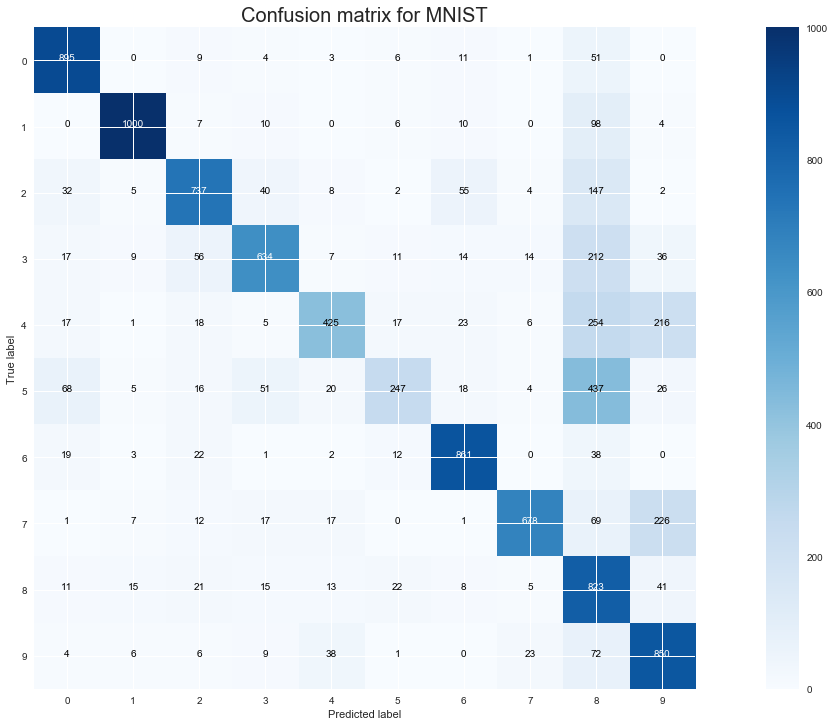

In [72]:
cm_mnist = confusion_matrix(mnist_test_label, predictions_mnist)
plot_confusion_matrix(cm_mnist, \
                      ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], \
                      title="Confusion matrix for MNIST")

cm_cifar = confusion_matrix(cifar10_test_label, predictions_cifar)
plot_confusion_matrix(cm_mnist, \
                      ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], \
                      title="Confusion matrix for MNIST")

<div class="alert alert-info">
Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved.
</div>

In [18]:
random_mnist = np.random.randint(low=0, high=10, size=len(mnist_test_label))
random_cifar = np.random.randint(low=0, high=10, size=len(cifar10_test_label))
correct_mnist = 0
for k in np.arange(len(mnist_test_data)):
    if random_mnist[k] == mnist_test_label[k]:
        correct_mnist += 1

correct_cifar = 0
for k in np.arange(len(cifar10_test_data)):
    if random_cifar[k] == cifar10_test_label[k]:
        correct_cifar += 1
print("Random classifier for MNIST:\tAccuracy: " + str(correct_mnist/100) + "%")
print("Random classifier for CIFAR:\tAccuracy: " + str(correct_cifar/100) + "%")

Random classifier for MNIST:	Accuracy: 9.77%
Random classifier for CIFAR:	Accuracy: 10.0%


<div class="alert alert-danger">
TODO
</div>

<div class="alert alert-warning">
<h3>Linear Regression</h3>
</div>

<div class="alert alert-info">
Implement Bayesian linear regression.
</div>

<div class="alert alert-info">
Treat class labels as continuous and apply regression to the training data.
</div>

<div class="alert alert-info">
Produce a scatter plot showing the predictions versus the true targets for the test set and compute the m  ean squared error on the test set.
</div>

<div class="alert alert-info">
Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy.
</div>

<div class="alert alert-info">
Discuss regression performance with respect to classification performance.
</div>

<div class="alert alert-danger">
TODO
</div>

<div class="alert alert-info">
Describe one limitation of using regression for this particular task.
</div>

<div class="alert alert-danger">
TODO
</div>

<div class="alert alert-warning">
<h3>Bonus question</h3>
</div>

<div class="alert alert-info">
The state-of-the-art in these image classification problems suggests that convolutional layers in convolutional neural networks yield most of the improvements compared to standard neural networks. The reason is that they are capable of modeling spatial patterns through the hierarchical analysis of patches of images. Propose and implement ways to exploit patch information in the Naïve Bayes classifier or linear regression. A couple of suggestions are: (i) apply Naïve Bayes classification to the output of convolutional layer in the LeNet architecture (ii) construct the Naïve Bayes classifier by calculating patch-specific statistics and extend this by stacking multiple of these
</div>